# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os

In [32]:
%matplotlib inline

# Open the .tif file
img = Image.open("/Users/khanhha/Desktop/Y3_S1/DATA3888/DATA3888_Project/Biotechnology/data_processed/morphology_focus.tif")


# Convert to numpy array
image_array = np.array(img)

# Calculate the quantile to scale intensity
quantile_value = np.quantile(image_array, 0.99)

# Scale intensity by dividing by the quantile
scaled_image_array = image_array / quantile_value

# Clip values greater than 1 to ensure image is within [0, 1] range
img2 = np.clip(scaled_image_array, 0, 1)

# Display the scaled image
# plt.imshow(img2, cmap='gray')  # Uncomment this line and below to display the whole image (this runs slow)
# plt.show()

In [33]:
cell_boundaries = pd.read_csv("/Users/khanhha/Desktop/Y3_S1/DATA3888/DATA3888_Project/Biotechnology/data_processed/cell_boundaries.csv.gz")
cell_boundaries['vertex_x_trans'] = cell_boundaries['vertex_x'].apply(lambda x: int(x/0.2125))
cell_boundaries['vertex_y_trans'] = cell_boundaries['vertex_y'].apply(lambda x: int(x/0.2125))

In [34]:
clusters = pd.read_csv("/Users/khanhha/Desktop/Y3_S1/DATA3888/DATA3888_Project/Biotechnology/data_processed/clusters.csv")
ncells = clusters.shape[0]
ncells

36553

In [35]:
img_pix = np.array(img)

In [10]:
random.seed(2024)

ncells_subset = 1000

cells_subset = random.sample(range(ncells), ncells_subset)

# clusters.loc[cells_subset, "Cluster"]

for i in cells_subset:
    # extract the boundary vertices for the selected cell
    bounds_i = cell_boundaries.loc[cell_boundaries["cell_id"] == i]

    # extract the cluster value for the selected cell
    clustval_i = clusters.loc[i,"Cluster"]

    # extract the pixel intensities for the area covering the cell boundary
    img_sub = img_pix[min(bounds_i["vertex_y_trans"]):max(bounds_i["vertex_y_trans"]),
                min(bounds_i["vertex_x_trans"]):max(bounds_i["vertex_x_trans"])]

    # normalise the pixel intensities according to 99th percentile
    img_sub_norm = img_sub/np.quantile(img_sub, 0.99)

    # as an example, display the image for the first selected cell
    if i in cells_subset[0:5]:
        print(f'Displaying image for cell {i}')
        # plt.imshow(img_sub_norm, cmap="gray")  # Uncomment this line and below to display sample cell images
        # plt.show()

    # create directory for images if it doesn't exist
    cell_dir = os.path.join(os.getcwd(), '/Users/khanhha/Desktop/Y3_S1/DATA3888/DATA3888_Project/Biotechnology/data_processed/cell_images_py')
    if not os.path.exists(cell_dir):
        os.mkdir(cell_dir)

    # create directory for cluster if it doesn't exist
    clust_dir = os.path.join(cell_dir, f'cluster_{clustval_i}')
    if not os.path.exists(clust_dir):
        os.mkdir(clust_dir)

    # save extracted image as a png file
    plt.imsave(os.path.join(clust_dir, f'cell_{i}.png'), img_sub_norm, cmap="gray")

NameError: name 'ncells' is not defined

# Part B

### Setup

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random 
import numpy as np
import os
import re

In [38]:
DATA_DIRECTORY = os.path.abspath('/Users/khanhha/Desktop/Y3_S1/DATA3888/DATA3888_Project/Biotechnology/data_processed')
CELL_IMAGES = os.path.join(DATA_DIRECTORY, 'cell_images_py')
SIZE=(50, 50)

## Loading in and displaying images

In [39]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f'cluster_{cluster}')
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    return [Image.open(file).convert("L") if None in size else Image.open(file).convert("L").resize(size) for file in files]

In [40]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [os.path.join(os.path.join(CELL_IMAGES, 'cluster_8'), file) for file in os.listdir(os.path.join(CELL_IMAGES, 'cluster_8'))]
cluster_B_files = [os.path.join(os.path.join(CELL_IMAGES, 'cluster_13'), file) for file in os.listdir(os.path.join(CELL_IMAGES, 'cluster_13'))]

In [41]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

In [11]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = nrows * 1  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis('off')

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()

display_images_in_grid(cluster_A_images_resized, ncols=10, cmap='gray')

NameError: name 'cluster_A_images_resized' is not defined

## Cell boundary and masking

### Setup

In [43]:
from shapely.geometry import Polygon
import rasterio
from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [44]:
cell_boundaries_raw = pd.read_csv("/Users/khanhha/Desktop/Y3_S1/DATA3888/DATA3888_Project/Biotechnology/data_processed/cell_boundaries.csv.gz")

def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f'cluster_{cluster}')
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r'cell_(\d+)\.png'
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [12]:
cell_boundaries = cell_boundaries_raw.loc[cell_boundaries_raw['cell_id'].isin(cluster_A_cell_ids + cluster_B_cell_ids)]

NameError: name 'cell_boundaries_raw' is not defined

In [46]:
def get_masked_image(image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries['cell_id'] == cell_id].copy()
    cell_boundary['vertex_x_scaled'] = 1 + ((cell_boundary['vertex_x'] - cell_boundary['vertex_x'].min()) * scaling_factor)
    cell_boundary['vertex_y_scaled'] = 1 + ((cell_boundary['vertex_y'] - cell_boundary['vertex_y'].min()) * scaling_factor)
    polygon = np.array(list(zip(cell_boundary['vertex_y_scaled'], cell_boundary['vertex_x_scaled'])))
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A),  np.invert(mask), fill_value=0)
    return masked_image

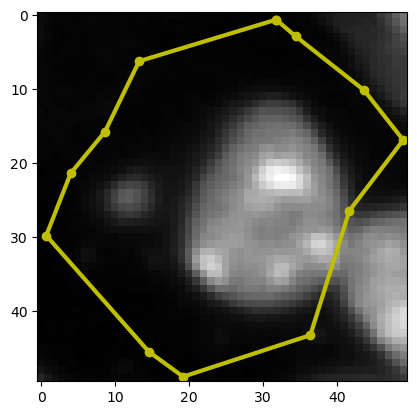

In [47]:
index = 0

cell_boundary = cell_boundaries[cell_boundaries['cell_id'] == cluster_A_cell_ids[index]].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary['vertex_x_scaled'] = (1 + ((cell_boundary['vertex_x'] - cell_boundary['vertex_x'].min()) * scaling_factor))*50/width
cell_boundary['vertex_y_scaled'] = (1 + ((cell_boundary['vertex_y'] - cell_boundary['vertex_y'].min()) * scaling_factor))*50/height

# Visualize the image
plt.clf()
plt.imshow(img_A_resized, cmap='gray')
plt.plot(cell_boundary['vertex_x_scaled'], cell_boundary['vertex_y_scaled'], 'y-o', linewidth=3)
plt.show()

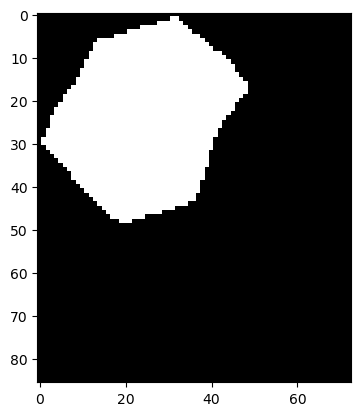

In [48]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(list(zip(cell_boundary['vertex_y_scaled'], cell_boundary['vertex_x_scaled'])))
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A),  np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap='gray')
plt.show()

### Masking all cells

In [6]:
SIZE = (50, 50)
def get_cluster_masked_images(cluster: int, size=(None, None), masked=False):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        if masked:
            # get shape of original image (without resize)
            height, width = np.array(image).shape
            # scaling factor for cell boundary, only if size is given
            resize_x = 50 / width if None not in size else 1
            resize_y = 50 / height if None not in size else 1

            # get cell boundary coordinates for the image
            cell_boundary = cell_boundaries.loc[
                cell_boundaries["cell_id"] == cell_id
            ].copy()
            # Calculate scaled x and y coordinates
            cell_boundary["vertex_x_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                    * scaling_factor
                )
            ) * resize_x
            cell_boundary["vertex_y_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                    * scaling_factor
                )
            ) * resize_y

            # create the mask
            polygon = np.array(
                list(
                    zip(
                        cell_boundary["vertex_y_scaled"],
                        cell_boundary["vertex_x_scaled"],
                    )
                )
            )
            mask = polygon2mask((height, width) if None in size else SIZE, polygon)
            # mask the image
            masked_image = np.ma.masked_array(
                np.copy(image if None in size else image_resized),
                np.invert(mask),
                fill_value=0,
            )
            result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        else:
            result[cell_id] = np.copy(image if None in size else image_resized)

    return result

In [8]:
masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=True)
    for cluster in range(1, 29)
}

unmasked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=False)
    for cluster in range(1, 29)
}

NameError: name 'get_cluster_images' is not defined

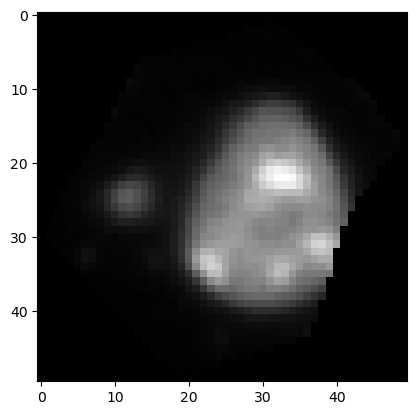

In [51]:
# display_images_in_grid(masked_cells[1])
plt.imshow(masked_cells[8][33839], cmap='gray')

## Random Forest 

### a. Pixel-based random forest

**Masked, resized, non-normalized images:**

In [122]:
X = []
y = []

for label, cells in masked_cells.items():
    for cell_id, image in cells.items():
        flattened_image = image.flatten()
        X.append(flattened_image)
        y.append(label)

X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3888)

# Training Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

from sklearn.metrics import classification_report, accuracy_score
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.18      0.33      0.23        15
           2       0.10      0.24      0.14        17
           3       0.17      0.39      0.23        18
           4       0.00      0.00      0.00        11
           5       0.07      0.08      0.07        13
           6       0.14      0.18      0.16        11
           7       0.17      0.33      0.22         9
           8       0.00      0.00      0.00         9
           9       0.08      0.11      0.10         9
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         7
          13       0.17      0.12      0.14         8
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         7
          17       0.00      0.00      0.00         5
          18       0.00    

/Users/khanhha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khanhha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khanhha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
# Cross validation 

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Create a Random Forest classifier
rf = RandomForestClassifier()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.125 0.115 0.195 0.115 0.18 ]
Mean CV accuracy: 0.146


### b. Extracted feature random forest

## KNN 

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': np.arange(1, 21),          # Number of neighbors
    'weights': ['uniform', 'distance'],   # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV with the KNN classifier, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

# Perform grid search
grid_search.fit(X, y)

# Get the best hyperparameters and the corresponding best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters:", best_params)
print("Best accuracy score:", best_score)

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 18, 'weights': 'uniform'}
Best accuracy score: 0.125
